In [180]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import numpy as np
plt.style.use('tableau-colorblind10')
#Set seed
np.random.seed(66)
random.seed(66)

In [181]:
train = pd.read_csv("/Users/pavemakouski/Documents/RP_records/Code/reserve/forecasting_challenge/train.csv")
test = pd.read_csv("/Users/pavemakouski/Documents/RP_records/Code/reserve/forecasting_challenge/test.csv")
test_og = test.columns
#Those are not available in the testing set
reduntant_columns = ['shutdown', 'mini_shutdown', 'blackout', 'frankfurt_shutdown','user_activity_1','user_activity_2']
train.drop(columns = reduntant_columns, inplace=True)

# EDA

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   warehouse               7340 non-null   object 
 1   date                    7340 non-null   object 
 2   orders                  7340 non-null   float64
 3   holiday_name            218 non-null    object 
 4   holiday                 7340 non-null   int64  
 5   shops_closed            7340 non-null   int64  
 6   winter_school_holidays  7340 non-null   int64  
 7   school_holidays         7340 non-null   int64  
 8   mov_change              7340 non-null   float64
 9   precipitation           7070 non-null   float64
 10  snow                    7070 non-null   float64
 11  id                      7340 non-null   object 
dtypes: float64(4), int64(4), object(4)
memory usage: 688.3+ KB


In [183]:
#Check unique holiday names
print(train['holiday_name'].unique())

[nan 'Christmas Eve' '2nd Christmas Day' 'New Years Day'
 'International womens day' 'Good Friday' 'Easter Monday' 'Labour Day'
 'Den osvobozeni' 'Cyrila a Metodej' 'Jan Hus' 'Den ceske statnosti'
 'Den vzniku samostatneho ceskoslovenskeho statu'
 'Den boje za svobodu a demokracii' 'Peace Festival in Augsburg'
 'Reformation Day' 'Memorial Day of the Republic'
 'Memorial Day for the Victims of the Communist Dictatorships'
 'Memorial Day for the Victims of the Holocaust' 'National Defense Day'
 'Day of National Unity' 'Independent Hungary Day'
 'Memorial Day for the Martyrs of Arad'
 '1848 Revolution Memorial Day (Extra holiday)' "All Saints' Day Holiday"]


In [184]:
#Unique warehouses
print(train['warehouse'].unique())

['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']


In [185]:
#Looking at the range of dates
print(min(train['date']))
print(max(train['date']))

2020-12-05
2024-03-15


In [186]:
def transform_dates(df):
    df = df.assign(
    date=pd.to_datetime(df['date']),
    year=lambda x: x['date'].dt.year,
    month=lambda x: x['date'].dt.month,
    week_number=lambda x: x['date'].dt.isocalendar().week,
    day=lambda x: x['date'].dt.day
    )
    df['weekday_name'] = df['date'].dt.day_name()
    df['weekend'] = (df['weekday_name'] == "Saturday") | (df['weekday_name'] == "Sunday")
    df = pd.get_dummies(df, columns=['weekday_name'], prefix='', prefix_sep='')
    df['month_beg_end'] = ((df['date'].dt.is_month_start) | (df['date'].dt.is_month_end)).astype(int)
    return df

train =transform_dates(train)
test = transform_dates(test)

## Grouping the data by date and warehouse

In [187]:
grouped = (train.groupby(['date', 'week_number', 'year', 'warehouse', 'month', 'day'])
                  .sum()
                  .reset_index())

## Working with holidays
While this dataset features most standard holidays (like Christmas and Easter), it does not include other potential shopping events (Black Friday, Valentine's day, and other days specific for each country)

In [188]:
def add_new_days(conditions, holiday_names, df):
    df['holiday_name'] = np.select(conditions, holiday_names, default=df['holiday_name'])
    return df

def initialize_conditions(grouped):
    conditions = [
        ((grouped['day'] >= 22) & (grouped['day'] <= 28) & (grouped['month'] == 11) & (grouped['week_number'] == 4)),  # Black Friday
        ((grouped['day'] == 14) & (grouped['month'] == 2)),  # Valentine's Day
        ((grouped['day'] == 31) & (grouped['month'] == 12)),  # New Year's Eve
        ((grouped['day'] == 1) & (grouped['month'] == 1)),  # New Year's Day
        ((grouped['day'] == 7) & (grouped['month'] == 1)),  # Orthodox Christmas
        ((grouped['day'] == 14) & (grouped['month'] == 1)),  # Another Orthodox Holiday
        ((grouped['day'] == 2) & (grouped['month'] == 5) & (grouped['year'] == 2021)),  
        ((grouped['day'] == 24) & (grouped['month'] == 4) & (grouped['year'] == 2022)),  
        ((grouped['day'] == 16) & (grouped['month'] == 4) & (grouped['year'] == 2023)),
        ((grouped['day'] == 5) & (grouped['month'] == 5) & (grouped['year'] == 2024))
    ]

    holiday_names = [
        'Black Friday',
        "Valentine's Day",
        "New Year's Eve",
        "New Year's Day",
        'Orthodox Christmas',
        "Orthodox New Year's",
        'Orthodox Easter',
        'Orthodox Easter',
        'Orthodox Easter',
        'Orthodox Easter'
    ]
    grouped = add_new_days(conditions, holiday_names, grouped)
    return grouped



grouped = initialize_conditions(grouped)
test = initialize_conditions(test)

### Pre-processing holidays for future analysis

In [189]:
#After grouping nones became zeroes
grouped['holiday_name'] = grouped['holiday_name'].replace(0, "Nope")
encoder = LabelEncoder()
grouped['holiday_name_encoded'] = encoder.fit_transform(grouped['holiday_name'])
grouped['is_holiday'] = grouped['holiday_name_encoded'] != 23

## Modelling

In [190]:
models = {}
season_dfs = {}
snow_dfs = {}
precipitation_dfs = {}
move_dfs = {}
columns_dfs ={}
predictions_dfs = {}

In [191]:
#Parameters for the XGBoost model
param_grid = {
    'max_depth': [3, 5, 7, 9, 12],
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.001],
    'subsample': [0.6, 0.8, 1.0],            
    'colsample_bytree': [0.6, 0.8, 1.0],     
    'gamma': [0, 0.1, 0.5],                  
    'min_child_weight': [1, 5, 10]           
}

Conducting analysis for each warehouse

In [192]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import uniform, randint
#Build the XGBoost function

def build_model(warehouse_sample, warehouse, param_grid, n_splits):
    tss = TimeSeriesSplit(n_splits)
    model = XGBRegressor(objective='reg:squarederror', random_state=66) #Change to your seed from the beginning 
    warehouse_data = warehouse_sample.sort_values(['date'], ascending=True)
    #Defining features
    X = warehouse_data.drop(columns=['date', 'orders', 'warehouse', 'holiday_name', 'id']) 
    columns_dfs[warehouse] = X.columns
    y = warehouse_data['orders']

    # Initialize time series cross-validation
    random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, 
    scoring='neg_mean_absolute_percentage_error', 
    n_iter=50,  # Number of random samples to try
    cv=tss, 
    random_state=66
    )
    # Fit the model using RandomizedSearchCV
    random_search.fit(X, y)

    # Save the best model and report its performance
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    predictions = best_model.predict(X)
    mape = mean_absolute_percentage_error(y, predictions)
    print(f"MAPE for {warehouse}: {mape:.2f}")
    print("Best Parameters:", best_params)
    return X, y, predictions, best_model


The warehouse is Brno_1
(1193, 27)


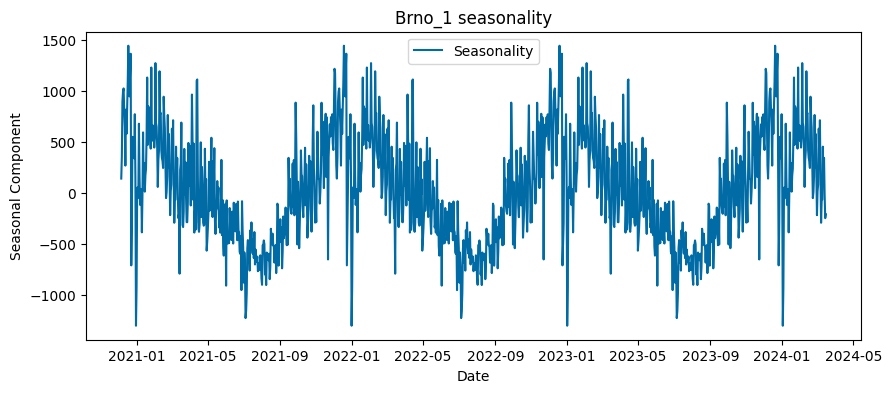

MAPE for Brno_1: 0.00
Best Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


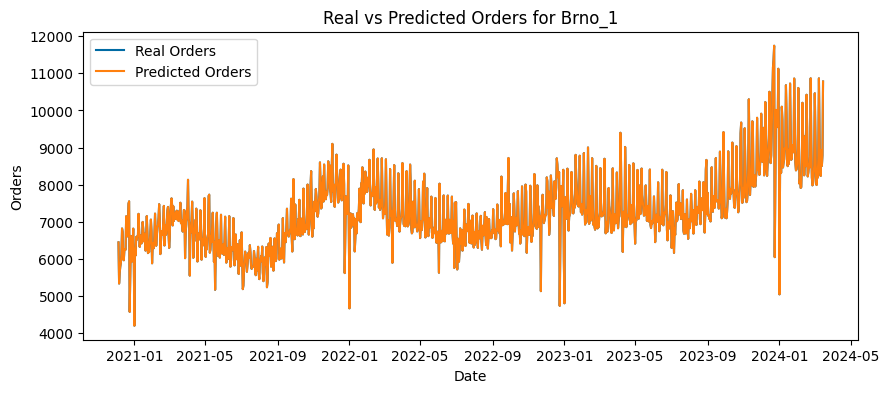

The warehouse is Budapest_1
(1154, 27)


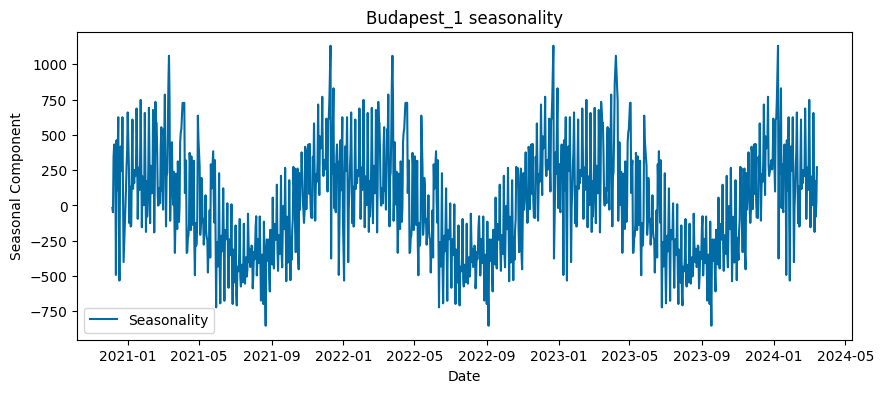

MAPE for Budapest_1: 0.01
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


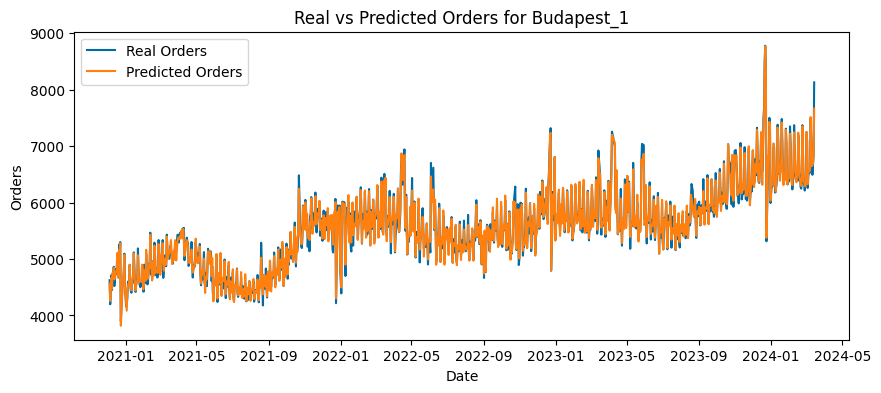

The warehouse is Prague_1
(1193, 27)


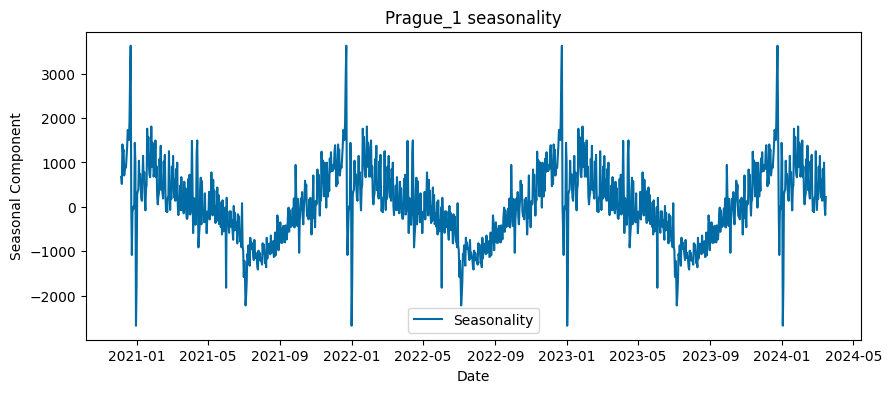

MAPE for Prague_1: 0.02
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}


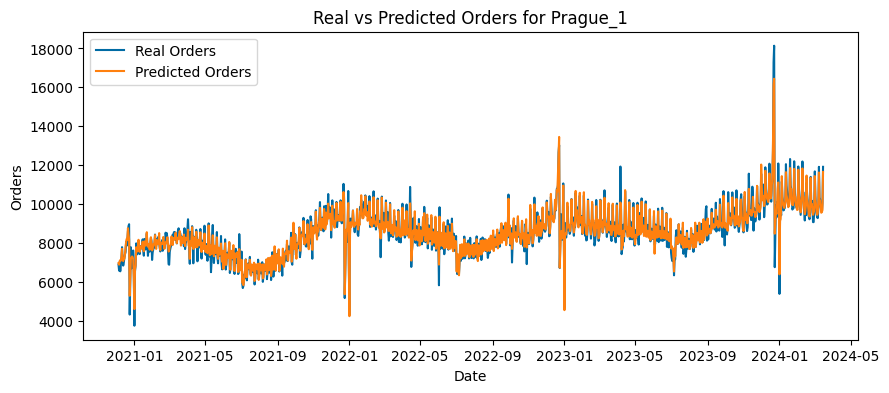

The warehouse is Prague_2
(1193, 27)


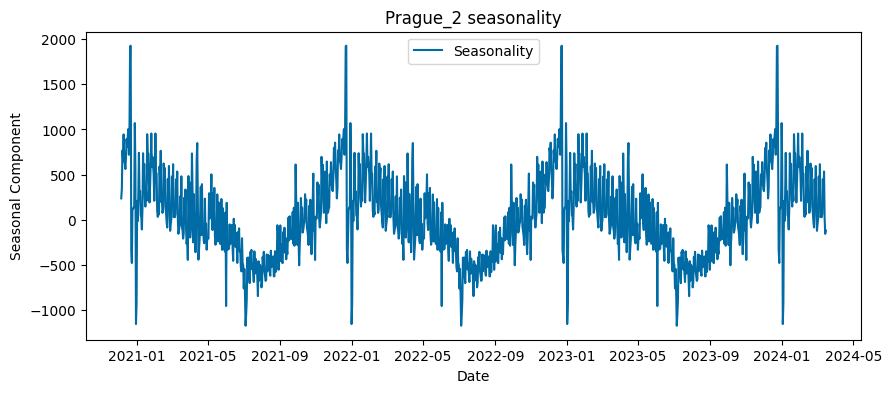

MAPE for Prague_2: 0.01
Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.8}


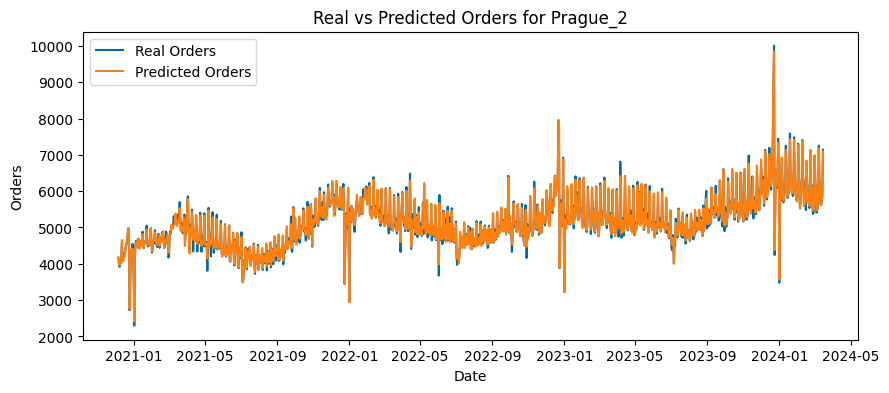

The warehouse is Prague_3
(1193, 27)


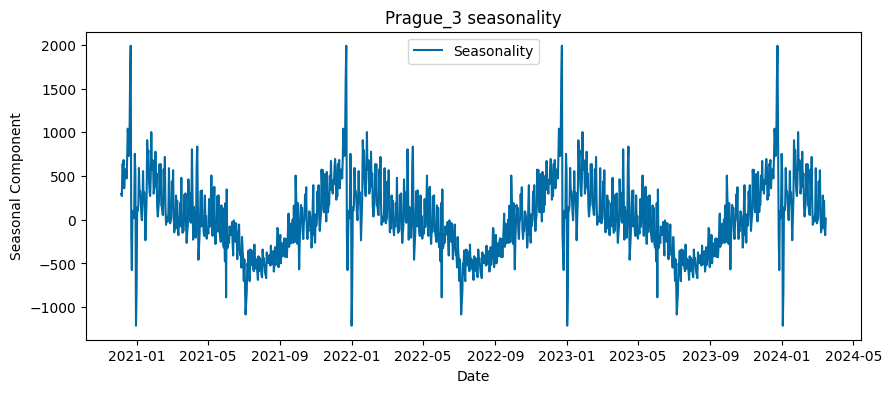

MAPE for Prague_3: 0.00
Best Parameters: {'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


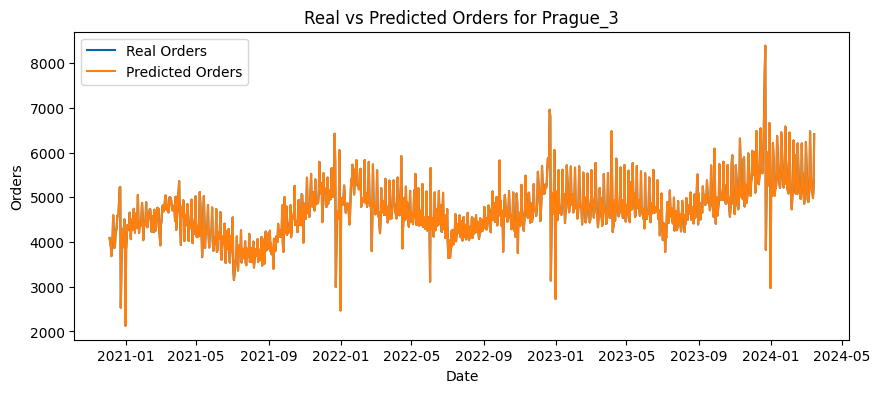

The warehouse is Munich_1
(785, 27)


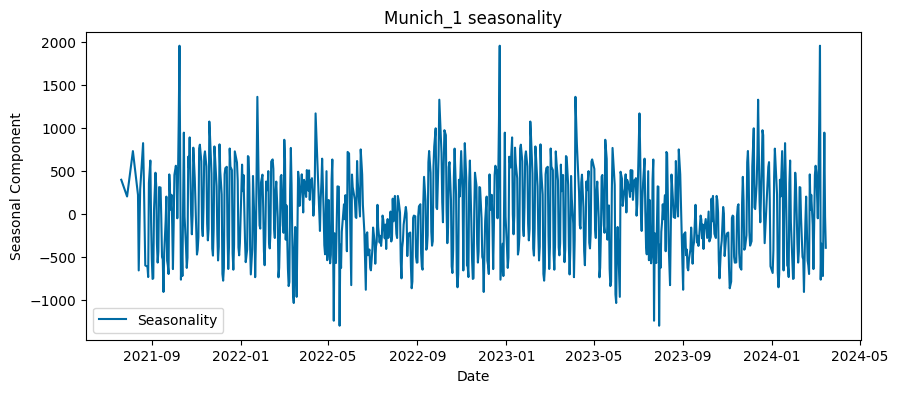

MAPE for Munich_1: 0.03
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}


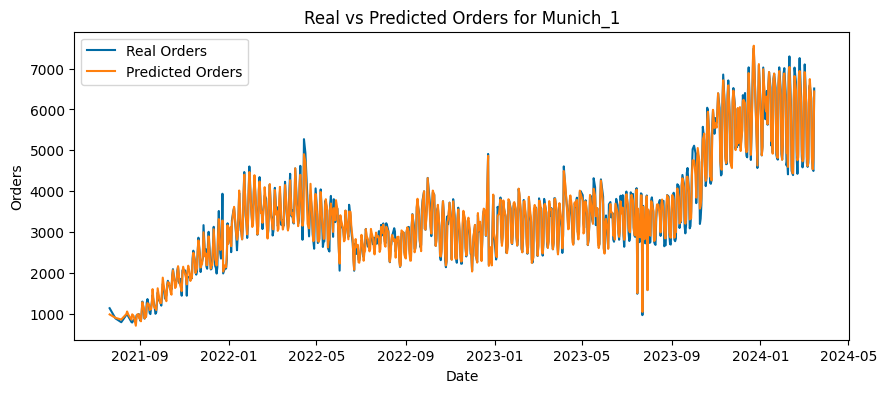

The warehouse is Frankfurt_1
(629, 27)


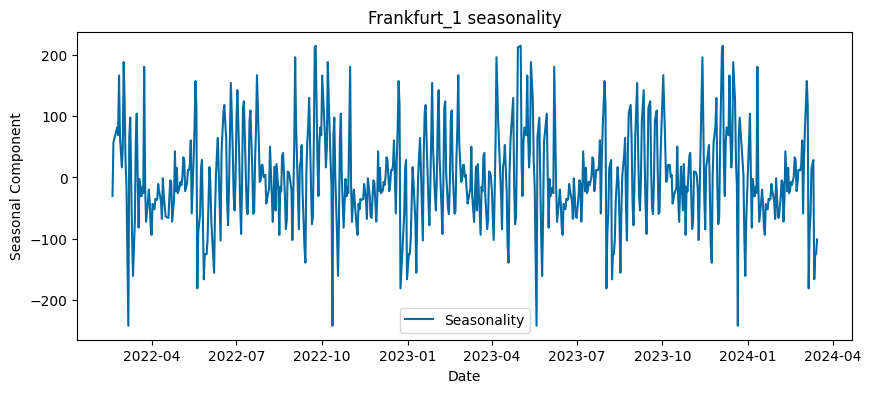

MAPE for Frankfurt_1: 0.02
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.6}


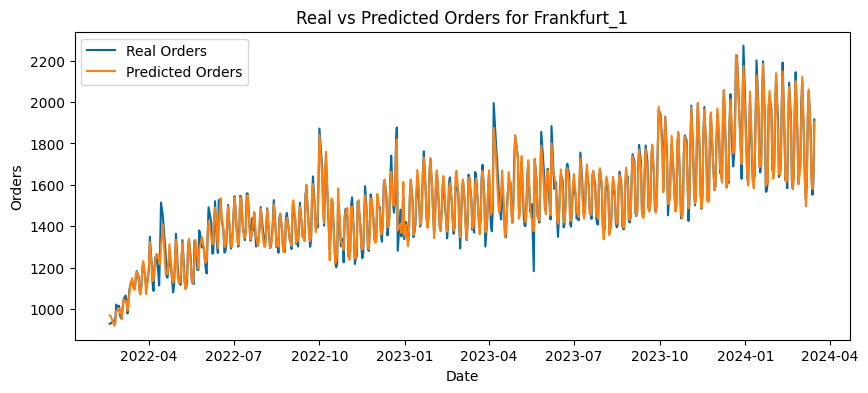

In [193]:
warehouses = grouped['warehouse'].unique()

for warehouse in warehouses:
    print(f'The warehouse is {warehouse}')
    warehouse_sample = grouped[grouped['warehouse'] == warehouse]
    warehouse_sample = warehouse_sample.sort_values('date', ascending = True)
    print(warehouse_sample.shape)
    # Seasonality extraction using seasonal_decompose from statsmodels for time series analysis
    period = 365 if warehouse_sample.shape[0] > 2 * 365 else 365 // 2
    
    if warehouse == 'Munich_1':
        period = 365
    elif warehouse == 'Frankfurt_1':
        period = 365 // 2

    # Perform seasonal decomposition
    result = seasonal_decompose(warehouse_sample['orders'], model='additive', period=period)
    # Add the seasonal component to the DataFrame
    warehouse_sample['seasonality'] = result.seasonal
    #Computing the mean seasonal effect for each warehouse and week
    season_df = warehouse_sample.groupby(['warehouse', 'week_number'])['seasonality'].mean().reset_index()
    season_dfs[f'season_{warehouse}'] = season_df
    #Computing the mean amount of snow for each warehouse per week
    snow_dfs[warehouse] = warehouse_sample.groupby(['warehouse', 'week_number'])['snow'].mean().reset_index()
    #Analogous action for precipitation
    precipitation_dfs[warehouse] = warehouse_sample.groupby(['warehouse', 'week_number'])['precipitation'].mean().reset_index()
    #Computing the mean change in the minimum order value
    move_dfs[warehouse] = warehouse_sample.groupby(['warehouse', 'week_number'])['mov_change'].mean().reset_index()
    #Plotting the seasonality for each warehouse
    plt.figure(figsize=(10, 4))
    plt.plot(warehouse_sample['date'], warehouse_sample['seasonality'], label='Seasonality')
    plt.title(f'{warehouse} seasonality')
    plt.xlabel('Date')
    plt.ylabel('Seasonal Component')
    plt.legend()
    plt.show()
    #Finding the right model
    X, y, predictions, best_model = build_model(warehouse_sample, warehouse, param_grid, 5)
    models[warehouse] = best_model
    # Creating a comparison df
    comp_df = pd.DataFrame({"y": y, "preds": predictions})
    predictions_dfs[warehouse] = comp_df
    
    #Real vs predicted values
    plt.figure(figsize=(10, 4))
    plt.plot(warehouse_sample['date'], y, label='Real Orders')
    plt.plot(warehouse_sample['date'], predictions, label='Predicted Orders')
    plt.title(f'Real vs Predicted Orders for {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    

In [194]:
# Looking at the MSE (just for the information component)
for key, d in predictions_dfs.items():
    print(f"The MSE for {key} is {mean_squared_error(d['y'], d['preds'])}")

The MSE for Brno_1 is 0.34851542762219156
The MSE for Budapest_1 is 7517.845623575474
The MSE for Prague_1 is 81232.36550800738
The MSE for Prague_2 is 6830.103428494101
The MSE for Prague_3 is 0.6308769793542413
The MSE for Munich_1 is 14871.524567647763
The MSE for Frankfurt_1 is 1110.271790475435


In [195]:
#The test set does not overlap with the training set 
print(min(test['date']))
print(max(test['date']))

2024-03-16 00:00:00
2024-05-15 00:00:00


### Using weather conditions as features

Although weather conditions are not available in the test set (i.e we do not know what the precipitation and snowing levels were for each warehouse in the Spring 2024), I will be using averaged weekly data from the previous years as features in model validation. It is not an optimal approach; however, I found that it greatly improves the accuracy of the model compared to when I drop climatic data altogether. I recognize that doing so introduces extra error as the data cannot account for the potential climatic anomalies and exogenous changes in consumer behaviour (caused by political events specific for each year, the overall economic situation, etc.). These data were not available to me as a part of this contest.

In [196]:
#Repeating a similar loop for the test set
final_df = pd.DataFrame()
columns = X.columns
for warehouse in warehouses:
    dfs = [snow_dfs[warehouse], season_dfs[f'season_{warehouse}'], 
           precipitation_dfs[warehouse], move_dfs[warehouse]]
    # Prevent the modification of the original dataset
    tw = test[test['warehouse'] == warehouse].copy()
    # Add the climate patterns, seasonality effects, and potential behaviour changes
    for daf in dfs:
       tw = tw.merge(daf, on=['week_number','warehouse'], how='left')
    tw['holiday_name'] = tw['holiday_name'].fillna('Nope')
    tw['holiday_name_encoded'] = encoder.transform(tw['holiday_name'])
    tw['is_holiday'] = tw['holiday_name_encoded'] != 23
    tw = tw.sort_values(['date'], ascending = True)
    test_features = tw[columns_dfs[warehouse]]
    model = models[warehouse]
    tw['orders'] = model.predict(test_features)
    final_df = pd.concat([final_df, tw], ignore_index= True)
    


In [197]:
final_df.head(10)

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,month,...,Tuesday,Wednesday,month_beg_end,snow,seasonality,precipitation,mov_change,holiday_name_encoded,is_holiday,orders
0,Brno_1,2024-03-16,Nope,0,0,0,0,Brno_1_2024-03-16,2024,3,...,False,False,0,0.076923,8.090369,2.054231,0.269231,23,False,9563.857422
1,Brno_1,2024-03-17,Nope,0,0,0,0,Brno_1_2024-03-17,2024,3,...,False,False,0,0.076923,8.090369,2.054231,0.269231,23,False,8740.664062
2,Brno_1,2024-03-18,Nope,0,0,0,0,Brno_1_2024-03-18,2024,3,...,False,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,8398.345703
3,Brno_1,2024-03-19,Nope,0,0,0,0,Brno_1_2024-03-19,2024,3,...,True,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,8627.628906
4,Brno_1,2024-03-20,Nope,0,0,0,0,Brno_1_2024-03-20,2024,3,...,False,True,0,0.000000,-10.652799,0.356190,0.333333,23,False,8486.596680
5,Brno_1,2024-03-21,Nope,0,0,0,0,Brno_1_2024-03-21,2024,3,...,False,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,8649.495117
6,Brno_1,2024-03-22,Nope,0,0,0,0,Brno_1_2024-03-22,2024,3,...,False,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,10630.504883
7,Brno_1,2024-03-23,Nope,0,0,0,0,Brno_1_2024-03-23,2024,3,...,False,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,9475.095703
8,Brno_1,2024-03-24,Nope,0,0,0,0,Brno_1_2024-03-24,2024,3,...,False,False,0,0.000000,-10.652799,0.356190,0.333333,23,False,8510.083008
9,Brno_1,2024-03-25,Nope,0,0,0,0,Brno_1_2024-03-25,2024,3,...,False,False,0,0.016190,144.984709,1.682857,0.333333,23,False,8194.838867
